### Exercise 1.

*Consider the problem of the owner of an oil field. The owner has B barrels of oil. She can
sell these barrels at price pt at time t. Her objective is to maximize the discounted present
value of sales of oil - we’ll assume there are no extraction costs. The owner discounts the
future at a rate given by $\frac{1}{1+r}$ (where $r$ is the real interest rate and assumed to be constant).
Answer the following:*

1. **_What are the state variables?_** The amount of oil $b_t$ at time $t$, and the price $p_t$ of each barrel at time $t$.
2. **_What are the control variables?_** The amount of oil to sell $k_t$ at time $t$.
3. **_What does the transition sequence look like?_** $b_{t+1}=b_t-k_t$
4. **_Write down the sequence problem of the owner. Write down the Bellman equation._** Sequence problem: $V = \underset{\{k_t\}_{t=1}^{\infty}}{\max}\sum_{t=1}^{\infty}(\frac{1}{1+r})^{t-1}(p_tk_t)$
<br>
Bellman equation: $V(b)=\underset{0\le x \le B}{\max}kp + \frac{1}{1+r}V(b-k)$ s.t. $\sum_{t=1}^{\infty}k_t=B$
5. **_What does the owner's Euler equation look like?_** $p_t=p_{t+1}\frac{1}{1+r}$
6. **_What would the solution of the problem look like if $p_{t+1}=p_t$ for all $t$? What would the solution look like if $p_{t+1}>(1+r)p_t$ for all $t$? What is the condition on the path of prices becessary for an interior solution (where the owner will extract some, but not all, of the oil)?_** If $p_{t+1}=p_t$ for all $t$, then we sell everything today becuase we get the same payoff from an addition unit sold in any period. Furthermore, we discount the future, so we will sell all of it today.
<br> If $p_{t+1}>(1+r)p_t$ for all $t$, then the amount of oil that we sell $k_t$ must be equal to $0$.
<br>
The condition for an interior solution is that $p_t(1+r)=p_{t+1}$

### Exercise 2.

*The Neoclassical Growth Model is a workhorse model in macroeconomics. The
problem for the social planner is to maximize the discounted expected utility for agents in the
economy:
\begin{align}
\underset{\{c\}_{t=0}^{\infty}}{\max}E_0\sum_{t=0}^{\infty}\beta^tu(c_t)
\end{align}
The resource constraint is given as:
\begin{align}
y_t = c_t + i_t
\end{align}
The law of motion for the capital stock is:
\begin{align}
k_{t+1} = (1-\delta)k_t + i_t
\end{align}
Output is determined by the aggregate production function:
\begin{align}
y_t=z_tk_t^\alpha
\end{align}
Assume that $z_t$ is stochastic. In particularm it is an i.i.d. process distributed as $ln(z)\sim N(0,\sigma_z)$.
*
1. **_What is (are) the state variable(s)?_** Capital stock $k_t$ today, and shock $z_t$ today
2. **_What are the control variables?_** Consumption $c_t$ today
3. **_Write down the Bellman Equation that represents this sequence problem._**
\begin{align}
V(k_t, z_t)=\underset{c}{\max}\{U(C_t)+\beta E_tV(k_{t+1}, z_{t+1})\}\;s.t.\;k_{t+1}+c_t=z_tk_t^{\alpha}+(1-\delta)k_t
\end{align}
4. **_Solve the growth model given the following parameterization (see Paramterization below):_**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

**Parameterization**
<br>
We define a set of parameter values as follows:


In [2]:
gamma = 0.5
beta = 0.96
delta = 0.05
alpha = 0.4
sigmaz = 0.2
mu = 0
rho = 0

We now create a grid space for the state space and for utility, modifying code written by Dr. Jason Debacker.

In [3]:
'''
------------------------------------------------------------------------
Create Grid for State Space - Capital and Shock
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid
size_k    = integer, number of grid points in capital state space
k_grid    = vector, size_k x 1 vector of capital grid points 
------------------------------------------------------------------------
'''
lb_k = 10
ub_k = 13
size_k = 40  # Number of grid points of k
size_z = 40 # Number of grid points of z
k_grid = np.linspace(lb_k, ub_k, size_k)

import ar1_approx as ar1
ln_z_grid, pi = ar1.addacooper(size_z, mu, rho, sigmaz)
z_grid = np.exp(ln_z_grid)
pi_z = np.transpose(pi)

In [4]:
'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption (c=z_tk_t^a - k_t+1 + (1-delta)k_t)
U        = matrix, current period utility value for all possible
           choices of w and w' (rows are w, columns w')
------------------------------------------------------------------------
'''

C = np.zeros((size_k, size_k, size_z))
for i in range(size_k): # loop over k_t
    for j in range(size_k): # loop over k_t+1
        for q in range(size_z): #loop over z_t
            C[i, j, q] = z_grid[q]* k_grid[i]**alpha + (1 - delta)*k_grid[i] - k_grid[j]
# replace 0 and negative consumption with a tiny value 
# This is a way to impose non-negativity on cons
C[C<=0] = 1e-15
if gamma == 1:
    U = np.log(C)
else:
    U = (C ** (1 - gamma)) / (1 - gamma)
U[C<0] = -9999999

We now proceed with value function iteration.

In [5]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of w and w'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of w' for all w 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-6 
VFdist = 7.0 
VFmaxiter = 500 
V = np.zeros((size_k, size_z)) # initial guess at value function
Vmat = np.zeros((size_k, size_k, size_z)) # initialize Vmat matrix
Vstore = np.zeros((size_k, size_z, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:
    for i in range(size_k): # loop over k_t
        for j in range(size_k): # loop over k_t+1
            for q in range(size_z): #loop over z_t
                EV = 0
                for qq in range(size_z):
                    EV += pi_z[q, qq]*V[j, qq]
                Vmat[i, j, q] = U[i, j, q] + beta * EV
      
    Vstore[:,:, VFiter] = V.reshape(size_k, size_z,) # store value function at each iteration for graphing later
    TV = Vmat.max(1) # apply max operator over k_t+1
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1 
    


if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Value function converged after this many iterations: 367


**_Plot the value function._**

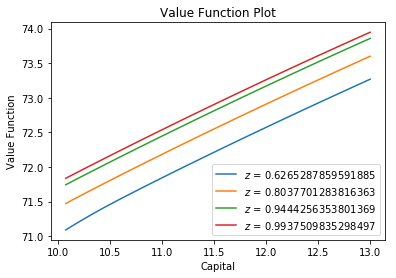

In [6]:
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], VF[1:, 0], label='$z$ = ' + str(z_grid[0]))
ax.plot(k_grid[1:], VF[1:, 5], label='$z$ = ' + str(z_grid[5]))
ax.plot(k_grid[1:], VF[1:, 15], label='$z$ = ' + str(z_grid[15]))
ax.plot(k_grid[1:], VF[1:, 19], label='$z$ = ' + str(z_grid[19]))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('medium')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Capital')
plt.ylabel('Value Function')
plt.title('Value Function Plot')
plt.show()

**_Plot the policy function for the choice of consumption._**

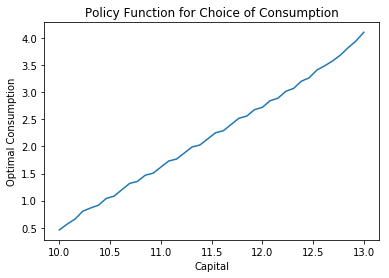

In [7]:
optK = k_grid[PF]
optC = z_grid * k_grid ** (alpha) + (1 - delta) * k_grid - optK
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optC[:][18], label='Consumption')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Capital')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function for Choice of Consumption')
plt.show()

**_Plot the policy function for the choice of capital next period._**

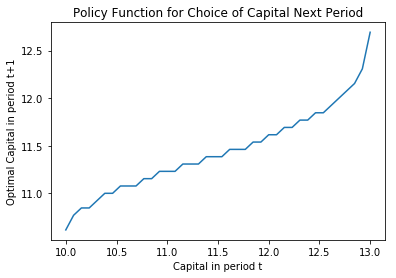

In [8]:
optK = k_grid[PF]
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optK[:][18], label='Capital in period t+1')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Capital in period t')
plt.ylabel('Optimal Capital in period t+1')
plt.title('Policy Function for Choice of Capital Next Period')
plt.show()

### Exercise 3.
Use the same neoclassical growth model as above, but consider the case where
there is serial correlation in the productivity shock. In particular, assume that $z_t$ is given by:
\begin{align}
ln(z_t)= \rho ln(z_{t-1}) + \nu_t
\end{align}
where $\nu_t \sim N(0,\sigma_\nu)$. Let $\rho=0.8$ and $\sigma_\nu=0.1$
<br>
<br>
1\. **_Write down the Bellman Equation that represents the planner's problem in this case (serial correlation in the productivity shock)._**
\begin{align}
V(k_t, z_t)=\underset{c}{\max}\{U(C_t)+\beta E_{z_{t+1}|z_t}V(k_{t+1}, z_{t+1})\}\;s.t\;k_{t+1}+c_t=z_tk_t^{\alpha}+(1-\delta)k_t
\end{align}

2\. **_Approximate the AR(1) process with a Markov chain and solve the model:_**


In [9]:
gamma = 0.5
beta = 0.96
delta = 0.05
alpha = 0.4
sigma_v = 0.1
mu = 0
rho = 0.8

We now create a grid space for the state space and for utility, modifying code written by Dr. Jason Debacker.

In [10]:
'''
------------------------------------------------------------------------
Create Grid for State Space - Capital and Shock
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid
size_k    = integer, number of grid points in capital state space
k_grid    = vector, size_k x 1 vector of capital grid points 
------------------------------------------------------------------------
'''
lb_k = 10
ub_k = 13
size_k = 40  # Number of grid points of k
size_z = 40 # Number of grid points of z
k_grid = np.linspace(lb_k, ub_k, size_k)

import ar1_approx as ar1
ln_z_grid, pi = ar1.addacooper(size_z, mu, rho, sigma_v)
z_grid = np.exp(ln_z_grid)
pi_z = np.transpose(pi)

In [11]:
'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption (c=z_tk_t^a - k_t+1 + (1-delta)k_t)
U        = matrix, current period utility value for all possible
           choices of k and k'
------------------------------------------------------------------------
'''

C = np.zeros((size_k, size_k, size_z))
for i in range(size_k): # loop over k_t
    for j in range(size_k): # loop over k_t+1
        for q in range(size_z): #loop over z_t
            C[i, j, q] = z_grid[q]* k_grid[i]**alpha + (1 - delta)*k_grid[i] - k_grid[j]
# replace 0 and negative consumption with a tiny value 
# This is a way to impose non-negativity on cons
C[C<=0] = 1e-15
if gamma == 1:
    U = np.log(C)
else:
    U = (C ** (1 - gamma)) / (1 - gamma)
U[C<0] = -9999999

We now proceed with value function iteration.

In [12]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of w and w'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of w' for all w 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-6 
VFdist = 7.0 
VFmaxiter = 500 
V = np.zeros((size_k, size_z)) # initial guess at value function
Vmat = np.zeros((size_k, size_k, size_z)) # initialize Vmat matrix
Vstore = np.zeros((size_k, size_z, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:
    for i in range(size_k): # loop over k_t
        for j in range(size_k): # loop over k_t+1
            for q in range(size_z): #loop over z_t
                EV = 0
                for qq in range(size_z):
                    EV += pi_z[q, qq]*V[j, qq]
                Vmat[i, j, q] = U[i, j, q] + beta * EV
      
    Vstore[:,:, VFiter] = V.reshape(size_k, size_z,) # store value function at each iteration for graphing later
    TV = Vmat.max(1) # apply max operator over k_t+1
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1 
    


if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation


Value function converged after this many iterations: 367


**_Plot the value function for at least 3 values of the productivity shock._**

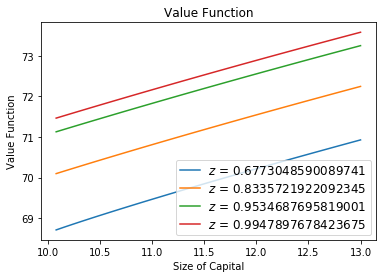

In [13]:
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], VF[1:, 0], label='$z$ = ' + str(z_grid[0]))
ax.plot(k_grid[1:], VF[1:, 5], label='$z$ = ' + str(z_grid[5]))
ax.plot(k_grid[1:], VF[1:, 15], label='$z$ = ' + str(z_grid[15]))
ax.plot(k_grid[1:], VF[1:, 19], label='$z$ = ' + str(z_grid[19]))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Value Function')
plt.title('Value Function')
plt.show()

**_Plot the policy function for the choice of consumption for at least 3 values of the productivity shock._**

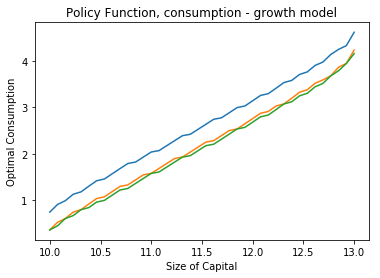

In [14]:
optK = k_grid[PF]
optC = z_grid * k_grid ** (alpha) + (1 - delta) * k_grid - optK
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optC[:][12], label='Consumption')
ax.plot(k_grid[:], optC[:][18], label='Consumption')
ax.plot(k_grid[:], optC[:][19], label='Consumption')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, consumption - growth model')
plt.show()

**_Plot the policy function for the choice of capital next period for at least 3 values of the productivity shock._**

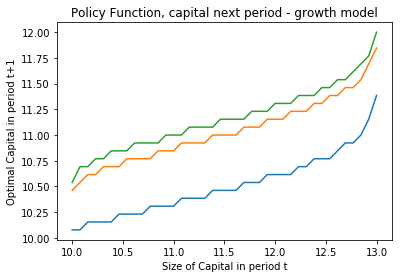

In [15]:
#Plot optimal capital in period t + 1 rule as a function of cake size
optK = k_grid[PF]
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optK[:][4], label='Capital in period t+1')
ax.plot(k_grid[:], optK[:][12], label='Capital in period t+1')
ax.plot(k_grid[:], optK[:][14], label='Capital in period t+1')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital in period t')
plt.ylabel('Optimal Capital in period t+1')
plt.title('Policy Function, capital next period - growth model')
plt.show()

### Exercise 4.
The search and matching model of labor markets is a key model in the macrolabor
literature. In one version of this model, potential workers receive wage offers from
a distribution of wages each period. Potential workers must decide whether to accept and
begin work at this wage (and work at this wage forever) or decline the offer and continue to
“search” (i.e., receive wage offers from some exogenous distribution).
<br>
The potential workers seek to maximize the expected, discounted sum of earnings: 
\begin{align}
E_0\sum_{t=0}^{\infty}\beta^ty_t
\end{align}
Income $y_t$, is equal to $w_t$ if employed. If unemployed, agents receive unemployment benefits $b$. 
<br>
    Assume that wage offers are distributed as $ln(w_t)\sim N(\mu,\sigma)$
1. **_Write down the Bellman equation representing this optimal problem._**
\begin{align}
V(w) = \max\{V^U(w),V^J(w)\}
\end{align}
for $V^U(w)=b+\beta EV(w)$ and $V^J(w)=E_0\sum_{t=0}^{\infty}\beta^tw=\frac{w}{1-\beta}$
2. **_Solve this model, using the following parameterization (see Parameterization below):_**

In [16]:
beta = 0.96
b = 0.05
mu = 0
sigma = .15
size_w = 100
rho = 0

In [17]:
w_grid = np.linspace(0.1, 2, size_w)
p_vals = np.empty_like(w_grid)

In [18]:
#Now we have to discretize the lognormal distribution
from scipy.stats import lognorm

p_vals[0] = 0
w_dist = lognorm(s=sigma, loc=mu)
for i in range(1, size_w):
    p_vals[i] = w_dist.cdf(w_grid[i]) - w_dist.cdf(w_grid[i-1])

In [19]:
#use numba for this problem

from numba import njit

@njit
def bellman_eq(b, beta, w_grid, p_vals, max_iter=500, 
               tol=1e-8, print_converge=True):
    V = w_grid / (1 - beta)
    TV = np.empty_like(V)
    PF = np.empty_like(V)
    iterate = 0
    difference = 1e3
    
    while iterate < max_iter and difference > tol:
        for i, w in enumerate(w_grid):
            V_unemp = b + beta * np.sum(V * p_vals)
            V_emp = w / (1 - beta)
            TV[i] = max(V_unemp, V_emp)
            
        difference = np.max(np.abs(TV - V))
        iterate = iterate + 1
        
        V = TV.copy()
        
    reswage = (1 - beta) * (b + beta * np.sum(V * p_vals))
        
    if print_converge:
            
        if iterate < max_iter:
            print('Value function converged after this any iterations:', iterate)
            print('The reservation wage is', reswage)
        else:
            print('Value function did not converge')
                
    return V, reswage

**_Find the “reservation wage” for the unemployed worker (i.e., the wage that makes
her indifferent between accepting the job offer and not)._**

In [20]:
V, r = bellman_eq(b, beta, w_grid, p_vals)

Value function converged after this any iterations: 40
The reservation wage is 1.0649181316397998


**_Plot the value function_**

[]

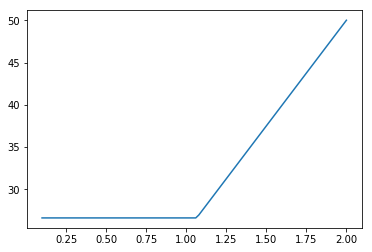

In [21]:
plt.plot(w_grid, V)
plt.plot()

**_Vary b from 0.5 to 1.0 and plot the reservation wage for each value of b. How do
unemployment benefits affect the reservation wage?_**

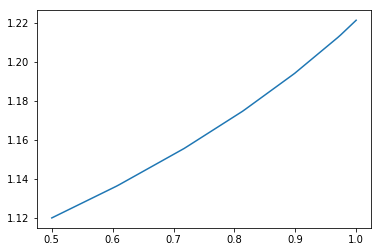

In [22]:
b_vals = np.linspace(0.5, 1, 100)
r_wage = np.zeros(len(b_vals))
for i, b_i in enumerate(b_vals):
    _, r_wage[i] = bellman_eq(b_i, beta, w_grid, p_vals, print_converge=False)

plt.plot(b_vals, r_wage)
plt.show()

As unemployment benefits increase, the reservation wage also increases. This makes sense -- if I get better benefits by staying unemployed, I will continue to wait until a better job offer/wage comes.